# 빅데이터 분석 (4주차) 10월5일
> 신경망의 표현력 

- toc:true
- branch: master
- badges: true
- comments: false
- author: 최서연
- categories: [Big Data Analysis, pytorch, Relu]

### Import 

In [2]:
import torch
import numpy as np
import matplotlib.pyplot as plt

### graphviz setting 

In [3]:
import graphviz

`-` 다이어그램을 그리기 위한 준비

In [4]:
def gv(s): return graphviz.Source('digraph G{ rankdir="LR"'+s + '; }')

### 예제1: 선형모형

`-` $y_i= w_0+w_1 x_i +\epsilon_i \Longrightarrow \hat{y}_i = \hat{w}_0+\hat{w}_1 x_i$ 

$\epsilon_i \sim N(0,1)$

- 모두 같은 표현,

- 원하는 바에 따라 입/출력 함수 변경하여 사용 가능

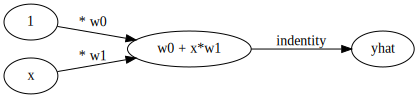

In [5]:
#collapse
gv(''' 
    "1" -> "w0 + x*w1"[label="* w0"]
    "x" -> "w0 + x*w1" [label="* w1"]
    "w0 + x*w1" -> "yhat"[label="indentity"]
    ''')

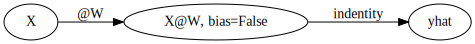

In [6]:
#collapse
gv('''
"X" -> "X@W, bias=False"[label="@W"] ;
"X@W, bias=False" -> "yhat"[label="indentity"] ''')

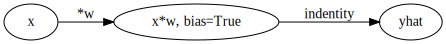

In [7]:
#collapse
gv('''
"x" -> "x*w, bias=True"[label="*w"] ;
"x*w, bias=True" -> "yhat"[label="indentity"] ''')

### 예제2: polynomial regression 

$y_i=w_0+w_1x_i + w_2 x_i^2 + w_3 x_i^3 +\epsilon_i$

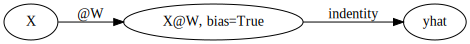

In [8]:
#collapse
gv('''
"X" -> "X@W, bias=True"[label="@W"]
"X@W, bias=True" -> "yhat"[label="indentity"] ''')

- bias term true 로 넣어줬으니까 상수항 없는 아래 항,

- bias term false로 원하면 상수항 있는 항 만들기

- ${\bf X} = \begin{bmatrix} 
x_1 & x_1^2 & x_1^3 \\ 
x_2 & x_2^2 & x_2^3 \\ 
\dots & \dots & \dots \\ 
x_n & x_n^2 & x_n^3 \\ 
\end{bmatrix}, \quad {\bf W} = \begin{bmatrix} 
w_1 \\ 
w_2 \\ 
w_3 
\end{bmatrix}$.

#### 시뮬레이션 연습

`-` 모형

In [9]:
torch.manual_seed(202150754)
x,_ = torch.randn(100).sort()
X=torch.vstack([x,x**2,x**3]).T
W=torch.tensor([[4.0],[3.0],[-2.0]])
bias=1.0 
ϵ=torch.randn(100,1)
y=X@W+bias + ϵ

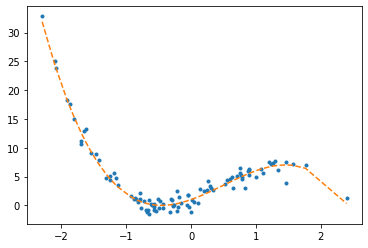

In [10]:
plt.plot(X[:,0],y,'.') # X의 첫번째 열
plt.plot(X[:,0],X@W+bias,'--') #이것은 y true 값! 어떻게 찾을 것이냐!

`-` 아키텍처 

In [11]:
net = torch.nn.Linear(in_features=3,out_features=1,bias=True) 

`-` for 문 적용할 손실함수

In [12]:
loss_fn=torch.nn.MSELoss() 

`-` 업데이트 할 옵티마이저 

In [13]:
optimizer= torch.optim.SGD(net.parameters(),lr=0.01) 

`-` step1~4

In [14]:
for epoc in range(1000): 
    ## 1
    yhat=net(X)
    ## 2
    loss=loss_fn(y,yhat)
    ## 3
    loss.backward()
    ## 4
    optimizer.step() 
    net.zero_grad()

In [15]:
list(net.parameters())

[Parameter containing:
 tensor([[ 3.9991,  3.0609, -2.0015]], requires_grad=True),
 Parameter containing:
 tensor([1.0014], requires_grad=True)]

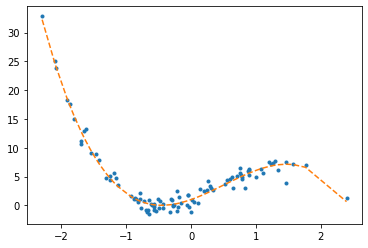

In [16]:
plt.plot(X[:,0],y,'.')
plt.plot(X[:,0],yhat.data,'--') # 미분 꼬리표 제거 할  .data 위 그림과 조금 차이나는 모습! 학습 잘 됐네!

### 예제3: piece-wise linear regression 계단함수 선형회귀

`-` 모델 

In [17]:
_x = np.linspace(-1,1,100).tolist()
_f = lambda x: x*1+np.random.normal()*0.3 if x<0 else x*3.5 +np.random.normal()*0.3 
_y = list(map(_f,_x))

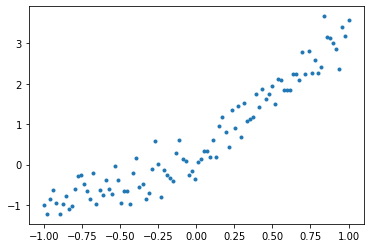

In [18]:
plt.plot(_x,_y,'.')
# 0보다 작으면 기울기가 1인 직선, 0보다 크면 기울기가 3.5인 직선

In [19]:
X=torch.tensor(_x).reshape(100,1) # shape 변경해줘서 계산되게끔 변경
y=torch.tensor(_y).reshape(100,1)

#### 풀이1

`-` 아키텍처 + 손실함수(MSE) + 옵티마이저(SGD) 

In [20]:
net=torch.nn.Linear(in_features=1,out_features=1,bias=True)
# bias가 true false 상관없음, 여기서는 bias term 너무 작아서 영향 안 끼칠 거니까.
loss_fn = torch.nn.MSELoss() 
optimizer = torch.optim.SGD(net.parameters(),lr=0.1) 

`-` step1~4

In [21]:
for epoc in range(10000): 
    ## 1
    yhat=net(X)
    ## 2
    loss=loss_fn(y,yhat)
    ## 3
    loss.backward()
    ## 4
    optimizer.step() 
    net.zero_grad()

In [22]:
list(net.parameters())

[Parameter containing:
 tensor([[2.1918]], requires_grad=True),
 Parameter containing:
 tensor([0.6388], requires_grad=True)]

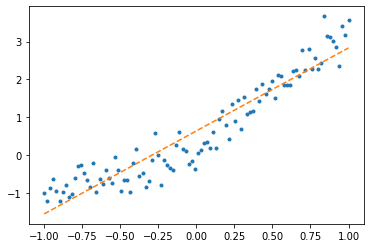

In [23]:
plt.plot(X,y,'.')
plt.plot(X,yhat.data,'--')

`-` 실패(구간별로 기울기가 다른 결과를 원함): 그리고 epoc을 10억번 반복해도 이건 실패할 모형임 
- 왜? 모델자체가 틀렸음. $\to$ 무조건 한 기울기의 직선만 나올 모델
- 모델의 표현력이 너무 부족하다. $\to$ underfitting 

#### 풀이2 (비선형 활성화함수를 도입)

`-` 비선형활성화함수를 도입하자. (네트워크수정)

In [24]:
torch.manual_seed(1)
layer1 = torch.nn.Linear(in_features=1,out_features=1,bias=False) 
activation1 = torch.nn.ReLU() 
layer2 = torch.nn.Linear(in_features=1,out_features=1,bias=False) 
net2 = torch.nn.Sequential(layer1,activation1,layer2) # 수열처럼 연결하기 위해

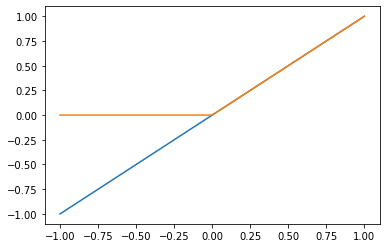

In [25]:
_x=np.linspace(-1,1,100)
plt.plot(_x,_x)
plt.plot(_x,activation1(torch.tensor(_x))) # x가 0보다 작으면 기울기 0으로 해주는 ReLU

`-` 표현력 확인 

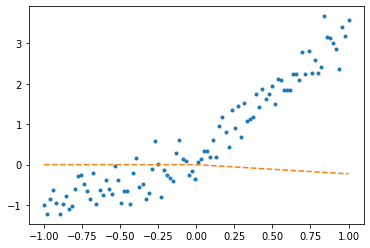

In [26]:
plt.plot(X,y,'.')
plt.plot(X,net2(X).data,'--')

`-` 옵티마이저2( 새로운 아키텍쳐 적용을 위해 만듦)

In [27]:
optimizer2 = torch.optim.SGD(net2.parameters(),lr=0.1)

`-` step1~4(손실함수는 같은 클래스 이용할 거라 건들지 않아도 됌)

In [28]:
for epoc in range(1000): 
    ## 1
    yhat=net2(X)
    ## 2
    loss=loss_fn(y,yhat)
    ## 3
    loss.backward()
    ## 4
    optimizer2.step() 
    net2.zero_grad()

`-` result

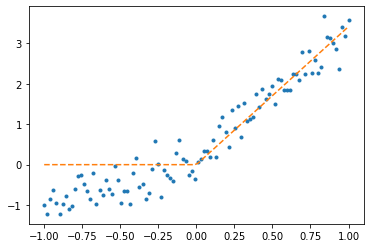

In [29]:
plt.plot(X,y,'.')
plt.plot(X,yhat.data,'--') # n수를 늘려봤자 기울기 0 또는 1(?) 밖에 안 나올 걸!

`-` discussion 
- 이것 역시 수백억번 epoc을 반복해도 이 이상 적합하기 힘들다.(두 가지 경우의 기울기만 존재) $\to$ 모형의 표현력이 낮다. 
- 해결책: 주황색점선이 2개 있다면 어떨까? 

#### 풀이3 (노드수 추가)

`-` 아키텍처 + 옵티마이저

In [30]:
torch.manual_seed(1) ## 초기가중치를 동일하게 
layer1 = torch.nn.Linear(in_features=1,out_features=2,bias=False) 
activation1 = torch.nn.ReLU() 
layer2 = torch.nn.Linear(in_features=2,out_features=1,bias=False) 
net3 = torch.nn.Sequential(layer1,activation1,layer2)
# 노드 수를 추가하여 layer 별 기울기(0 전후로 나뉘어 다른)를 더해주기
optimizer3= torch.optim.SGD(net3.parameters(),lr=0.1)

* Relu (class)
    - Applies the rectified linear unit function element-wise:
    - $Relu(x)=(x)^{+}=max(0,x)
    - parameter : inplace – can optionally do the operation in-place. Default: False
    
    - shape
    - Input: $(*)$ where $*$ means any number of dimensions.
    - Output: $(*)$, same shape as the input.



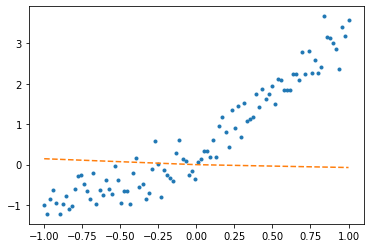

In [31]:
plt.plot(X,y,'.')
plt.plot(X,net3(X).data,'--')

`-` Step 1~4 

In [32]:
for epoc in range(1000): 
    ## 1
    yhat=net3(X)
    ## 2
    loss=loss_fn(y,yhat)
    ## 3
    loss.backward()
    ## 4
    optimizer3.step() 
    net3.zero_grad()

`-` result

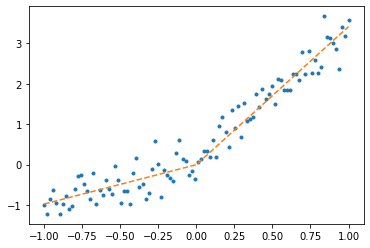

In [33]:
plt.plot(X,y,'.')
plt.plot(X,yhat.data,'--')

`-` discussion 

In [34]:
list(net3.parameters()) # 파라미터들이 잘 추정되었을까? 
# net3.weight로는 확인 못 하고 parameters 로 확인 가능
# 왜냐하면 net3는 layer1이랑 layer2를 더한 것이기 때문

[Parameter containing:
 tensor([[ 1.8738],
         [-1.0061]], requires_grad=True),
 Parameter containing:
 tensor([[ 1.8204, -0.9666]], requires_grad=True)]

- 파라메터확인 

In [35]:
W1=(layer1.weight.data).T # 1*2를 2*1로 바꾸기 위해
W2=(layer2.weight.data).T
W1,W2

(tensor([[ 1.8738, -1.0061]]),
 tensor([[ 1.8204],
         [-0.9666]]))

- 파라메터 저장 

`-` 어떻게 적합이 이렇게 우수하게 되었는지 따져보자. 

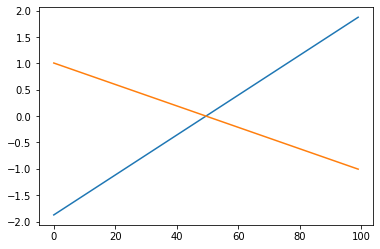

In [36]:
u1=X@W1
plt.plot(u1)
#plt.plot(X@W1)

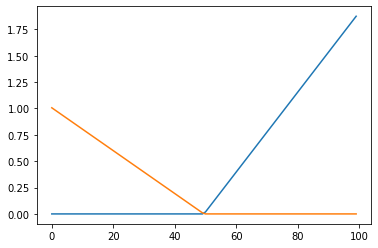

In [37]:
v1=activation1(u1)
plt.plot(v1)
#plt.plot(activation1(X@W1))
# ReLU 해주면?

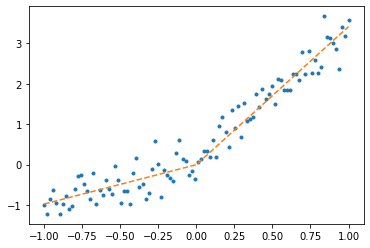

In [38]:
_yhat=v1@W2 
plt.plot(X,y,'.')
plt.plot(X,_yhat,'--')
#plt.plot(X,activation1(X@W1)@W2,'--')

#### 잠깐요약 (신경망)

`-` 계산과정 

(1) $X \to X@W^{(1)} \to ReLU(X@W^{(1)}) \to ReLU(X@W^{(1)})@W^{(2)}=yhat$

- $X: n \times 1$
- $W^{(0)}: 1 \times 2$
- $W^{(1)}: 2 \times 1$

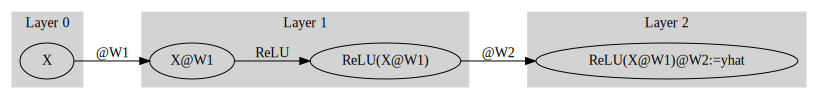

In [39]:
#collapse
gv('''
subgraph cluster_1{
    style=filled;
    color=lightgrey;
    "X" 
    label = "Layer 0"
}
subgraph cluster_2{
    style=filled;
    color=lightgrey;
    "X" -> "X@W1"[label="@W1"]
    "X@W1" -> "ReLU(X@W1)"[label="ReLU"]
    label = "Layer 1"
}
subgraph cluster_3{
    style=filled;
    color=lightgrey;
    "ReLU(X@W1)" -> "ReLU(X@W1)@W2:=yhat"[label="@W2"]
    label = "Layer 2"
}
''')

(2) 아래와 같이 표현할 수도 있다. 

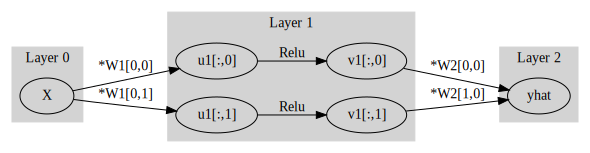

In [42]:
#collapse
gv('''
subgraph cluster_1{
    style=filled;
    color=lightgrey;
    "X" 
    label = "Layer 0"
}
subgraph cluster_2{
    style=filled;
    color=lightgrey;
    "X" -> "u1[:,0]"[label="*W1[0,0]"]
    "X" -> "u1[:,1]"[label="*W1[0,1]"]
    "u1[:,0]" -> "v1[:,0]"[label="Relu"]
    "u1[:,1]" -> "v1[:,1]"[label="Relu"]
    label = "Layer 1"
}
subgraph cluster_3{
    style=filled;
    color=lightgrey;
    "v1[:,0]" -> "yhat"[label="*W2[0,0]"]
    "v1[:,1]" -> "yhat"[label="*W2[1,0]"]
    label = "Layer 2"
}
''')

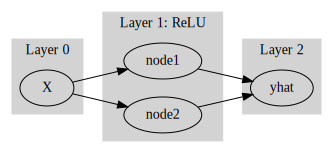

In [43]:
#collapse
gv('''
subgraph cluster_1{
    style=filled;
    color=lightgrey;
    "X" 
    label = "Layer 0"
}
subgraph cluster_2{
    style=filled;
    color=lightgrey;
    "X" -> "node1"
    "X" -> "node2"
    label = "Layer 1: ReLU"
}
subgraph cluster_3{
    style=filled;
    color=lightgrey;
    "node1" -> "yhat"
    "node2" -> "yhat"
    label = "Layer 2"
}
''')

- 깊은 신경망: 레이어 수가 많은 것
- 넓은 신경망: 노드 수가 많은 것

`-` 위와 같은 다이어그램을 적용하면 예제1은 아래와 같이 표현가능 

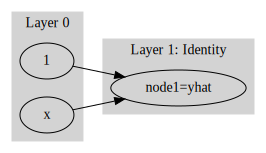

In [44]:
#collapse
gv('''
subgraph cluster_1{
    style=filled;
    color=lightgrey;
    "1" 
    "x" 
    label = "Layer 0"
}
subgraph cluster_2{
    style=filled;
    color=lightgrey;
    "1" -> "node1=yhat"
    "x" -> "node1=yhat"
    label = "Layer 1: Identity"
}
''')

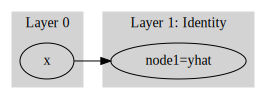

In [45]:
#collapse
gv('''
subgraph cluster_1{
    style=filled;
    color=lightgrey;
    "x" 
    label = "Layer 0"
}
subgraph cluster_2{
    style=filled;
    color=lightgrey;
    "x" -> "node1=yhat"
    label = "Layer 1: Identity"
}
''')

`-` 예제2의 아키텍처 

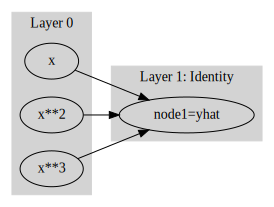

In [46]:
#collapse
gv('''
subgraph cluster_1{
    style=filled;
    color=lightgrey;
    "x" 
    "x**2" 
    "x**3" 
    label = "Layer 0"
}
subgraph cluster_2{
    style=filled;
    color=lightgrey;
    "x" -> "node1=yhat"
    "x**2" -> "node1=yhat"
    "x**3" -> "node1=yhat"
    label = "Layer 1: Identity"
}
''')

#### 풀이3이 실패할 수도 있음 

`-` 아키텍처 + 옵티마이저

In [40]:
torch.manual_seed(202150754) ## 초기가중치를 동일하게 
layer1 = torch.nn.Linear(in_features=1,out_features=2,bias=False) 
activation1 = torch.nn.ReLU() 
layer2 = torch.nn.Linear(in_features=2,out_features=1,bias=False) 
net3 = torch.nn.Sequential(layer1,activation1,layer2) 
optimizer3= torch.optim.SGD(net3.parameters(),lr=0.1)

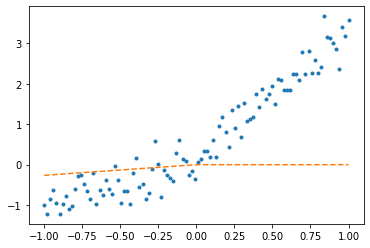

In [41]:
plt.plot(X,y,'.')
plt.plot(X,net3(X).data,'--')

`-` Step 1~4 

In [42]:
for epoc in range(10000): 
    ## 1
    yhat=net3(X)
    ## 2
    loss=loss_fn(y,yhat)
    ## 3
    loss.backward()
    ## 4
    optimizer3.step() 
    net3.zero_grad()

`-` result

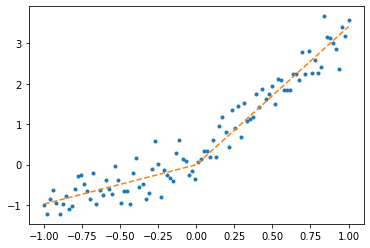

In [43]:
plt.plot(X,y,'.')
plt.plot(X,yhat.data,'--')

`-` 왜 가중치가 변하지 않는가? (이것보다 더 좋은 fitting이 있음을 우리는 이미 알고있는데..)

In [44]:
W1=(layer1.weight.data).T
W2=(layer2.weight.data).T
W1,W2

(tensor([[-1.0609,  1.8429]]),
 tensor([[-0.9166],
         [ 1.8509]]))

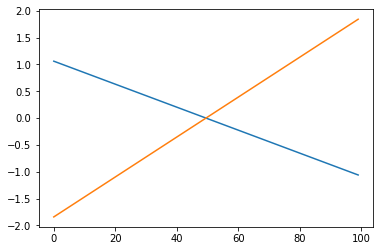

In [45]:
u1=X@W1
plt.plot(u1)
#plt.plot(X@W1)

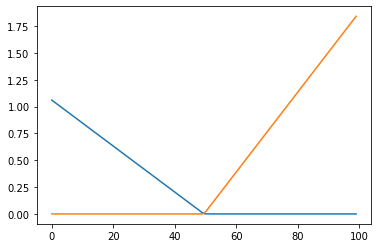

In [46]:
v1=activation1(u1)
plt.plot(v1)
#plt.plot(activation1(X@W1))

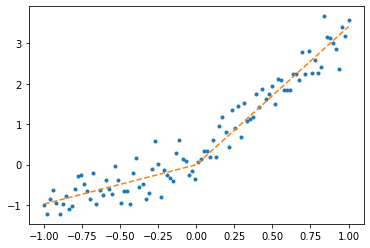

In [47]:
_yhat=v1@W2 
plt.plot(X,y,'.')
plt.plot(X,_yhat,'--')
#plt.plot(X,activation1(X@W1)@W2,'--')

`-` 고약한 상황에 빠졌음. 

#### 풀이4: 넓은 신경망(노드 수 많은)

`-` Custom Activation Function 

In [48]:
# simply define a mooyaho function
   
def mooyaho(input):
    return torch.sigmoid(200*input)
    
class MOOYAHO(torch.nn.Module):
    def __init__(self):
        super().__init__() # init the base class

    def forward(self, input):
        return mooyaho(input) # simply apply already implemented SiLU

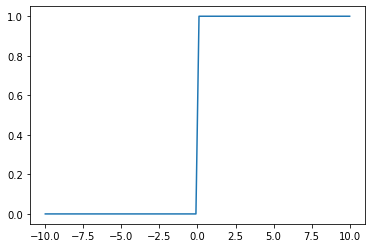

In [49]:
_x=torch.linspace(-10,10,100)
plt.plot(_x,mooyaho(_x))

`-` 아키텍처

In [50]:
torch.manual_seed(1) # 초기가중치를 똑같이 하기 위해서.. 
layer1=torch.nn.Linear(in_features=1,out_features=500,bias=True) # 노드 500개 만들기
activation1=MOOYAHO() 
layer2=torch.nn.Linear(in_features=500,out_features=1,bias=True)
net4=torch.nn.Sequential(layer1,activation1,layer2)
optimizer4=torch.optim.SGD(net4.parameters(),lr=0.001) 

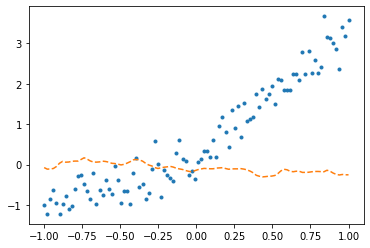

In [51]:
plt.plot(X,y,'.')
plt.plot(X,net4(X).data,'--')

`-` step1~4

In [52]:
for epoc in range(5000):
    # 1 
    yhat=net4(X)
    # 2
    loss=loss_fn(yhat,y) 
    # 3 
    loss.backward()
    # 4 
    optimizer4.step()
    net4.zero_grad() 

`-` result

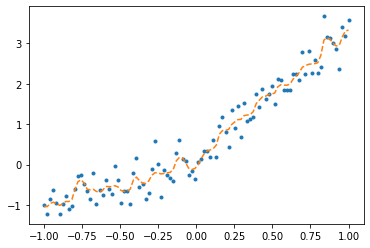

In [53]:
plt.plot(X,y,'.')
plt.plot(X,yhat.data,'--')

`-` 넓은 신경망은 과적합을 하는 경우가 종종있다. 

`-` 무엇이든 맞출 수 있음

    - 좋다는 뜻이 아님,
    - error term은 최대한 안 건들여야

In [54]:
torch.manual_seed(202150754)
__X = torch.linspace(-1,1,100).reshape(100,1)
__y = torch.randn(100,1)

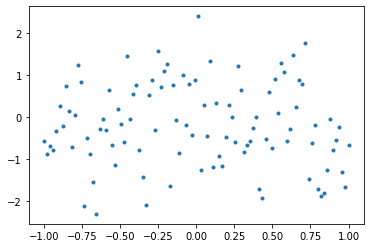

In [55]:
plt.plot(__X,__y,'.')

In [56]:
torch.manual_seed(1) # 초기가중치를 똑같이 하기 위해서.. 
layer1=torch.nn.Linear(in_features=1,out_features=500,bias=True)
activation1=MOOYAHO() 
layer2=torch.nn.Linear(in_features=500,out_features=1,bias=True)
net4=torch.nn.Sequential(layer1,activation1,layer2)
optimizer4=torch.optim.SGD(net4.parameters(),lr=0.001) 

`-` step1~4

In [57]:
for epoc in range(5000):
    # 1 
    __yhat=net4(__X)
    # 2
    loss=loss_fn(__yhat,__y) 
    # 3 
    loss.backward()
    # 4 
    optimizer4.step()
    net4.zero_grad() 

`-` result

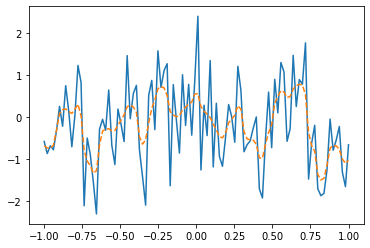

In [63]:
plt.plot(__X,__y)
plt.plot(__X,__yhat.data,'--')
# 잘 맞추는 것 처럼 보이지만

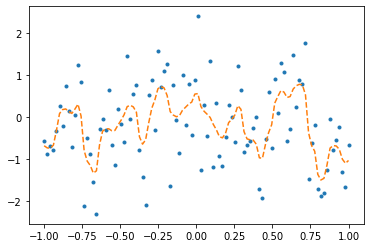

In [64]:
plt.plot(__X,__y,'.')
plt.plot(__X,__yhat.data,'--')
# 직선으로 fitting되어야 겠지?

In [62]:
loss_fn(__y,__y*0), loss_fn(__y,__yhat.data)

(tensor(1.0025), tensor(0.4611))

### 숙제

`-` 예제2: polynomial regression 에서 

```python
optimizer= torch.optim.SGD(net.parameters(),lr=0.01) 
```

대신에 

```python
optimizer= torch.optim.SGD(net.parameters(),lr=0.1) 
```

로 변경하여 학습하고 결과를 관찰할것. 

설명: 위와 같은 결과가 나온 이유는... 

In [74]:
torch.manual_seed(202150754)
x,_ = torch.randn(100).sort()
X=torch.vstack([x,x**2,x**3]).T
W=torch.tensor([[4.0],[3.0],[-2.0]])
bias=1.0 
ϵ=torch.randn(100,1)
y=X@W+bias + ϵ

In [84]:
net = torch.nn.Linear(in_features=3,out_features=1,bias=True) 
loss_fn=torch.nn.MSELoss() 
optimizer= torch.optim.SGD(net.parameters(),lr=0.1)

In [85]:
for epoc in range(1000): 
    ## 1
    yhat=net(X)
    ## 2
    loss=loss_fn(y,yhat)
    ## 3
    loss.backward()
    ## 4
    optimizer.step() 
    net.zero_grad()

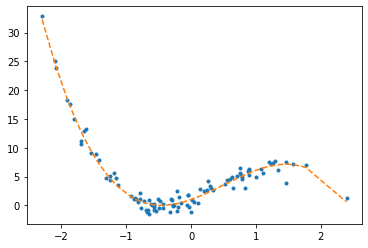

In [86]:
plt.plot(X[:,0],y,'.')
plt.plot(X[:,0],yhat.data,'--') # 미분 꼬리표 제거 할  .data 위 그림과 조금 차이나는 모습! 학습 잘 됐네!